In [616]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats

In [617]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context='poster', style='whitegrid', palette='viridis')

#### Loading malls visits

In [618]:
UserMallVisits = pd.read_csv("data/user_mall.csv")
print(UserMallVisits.shape)
UserMallVisits.head(3)

(1471637, 3)


,person_id,mall_id,number_days
0,00000f8f8a6230a9ddee70296710bd14,18.0,2
1,0000184431ba3bec8d633d7fae68f150,9.0,1
2,00002bac82e5c607965a11f68eeb1f6f,16.0,1


#### Loading home location

In [619]:
UserHomeLocation = pd.read_csv("data/user_home.csv")
print(UserHomeLocation.shape)
UserHomeLocation.head(3)

(398711, 2)


,person_id,home_tower
0,12ce065aaaa7035e1a9ec73e260e8c75,NTSUF
1,b9036ea9624296d0f846b7edfef6413f,JPAG1
2,8d58c60c745b4dfb8738098a86a7f87a,CREJF


#### Loading population per city square (computed from census data at the 'census zone' level)

In [620]:
PopulationPerSquare = pd.read_csv("data/population_per_square.csv")
print(PopulationPerSquare.shape)
PopulationPerSquare.head(3)

(470, 3)


,lat,lon,population
0,-33.62,-70.63,1368.907578
1,-33.61,-70.64,929.217356
2,-33.60,-70.67,66.650754


#### Loading malls data

In [621]:
MallsList = pd.read_csv("data/malls_list.csv")
print(MallsList.shape)
MallsList[["mall_description", "mall_id", "mall_lat", "mall_lon", "mall_rental_space", "mall_visitors"]].head(3)

(16, 6)


,mall_description,mall_id,mall_lat,mall_lon,mall_rental_space,mall_visitors
0,Mall Plaza Alameda,16.0,-33.452770,-70.682171,60000,26478
1,Mall Plaza Oeste,19.0,-33.517440,-70.717430,144000,148716
2,Mall Florida Center,12.0,-33.510524,-70.608436,110000,145436


In [622]:
X = UserMallVisits.merge(MallsList[["mall_id", "mall_description", "mall_lat", "mall_lon", "mall_rental_space", "mall_visitors"]])

In [623]:
X = X.merge(UserHomeLocation)

In [624]:
print(X.shape)
X.head(3)

(649295, 9)


,person_id,mall_id,number_days,mall_description,mall_lat,mall_lon,mall_rental_space,mall_visitors,home_tower
0,0001425599a9002de299a4de46c1333b,18.0,3,Mall Plaza Norte,-33.364834,-70.678337,74900,127768,4CENF
1,00018831c6686a941136c01b29ed1f6b,18.0,2,Mall Plaza Norte,-33.364834,-70.678337,74900,127768,CCARO
2,000454ebed19c43c62e3996c9a6b1f6e,18.0,4,Mall Plaza Norte,-33.364834,-70.678337,74900,127768,LBARF


#### Computing distances from home to mall

In [625]:
Antennas = pd.read_csv("data/antennas_by_comuna.csv")
Antennas.lat = [np.round(s, 2) for s in Antennas.lat]
Antennas.lon = [np.round(s, 2) for s in Antennas.lon]
Antennas = Antennas[["tower", "lat", "lon"]].groupby("tower").first().reset_index()

In [626]:
#We compute the distance from each user square to the mall
X = X.merge(Antennas, left_on = "home_tower", right_on="tower")
X.drop("tower", axis=1, inplace = True)

In [627]:
import math

def distance_on_unit_sphere(lat1, long1, lat2, long2):

    # Convert latitude and longitude to
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0

    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians

    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians

    # Compute spherical distance from spherical coordinates.

    # For two locations in spherical coordinates
    # (1, theta, phi) and (1, theta, phi)
    # cosine( arc length ) =
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length

    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) +
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos( round(cos,14) )

    #In kilometers
    return arc*6373



In [628]:
X["distance_home_mall"] = [distance_on_unit_sphere(lat1, long1, lat2, long2) 
                           for (lat1, long1, lat2, long2) in
                           zip(X.lat, X.lon, X.mall_lat, X.mall_lon + 0.005)]

In [629]:
X = X.merge(PopulationPerSquare)

In [630]:
#Reorganizing columns...
X = X[['person_id', 'home_tower', 'lat', 'lon', 'population', 'mall_id', 'mall_description', 'mall_lat',
       'mall_lon', 'mall_rental_space', 'mall_visitors', 'number_days', 'distance_home_mall']]

In [631]:
X.columns = ['person_id', 'home_tower', 'home_lat', 'home_lon', 'home_population', 'mall_id', 'mall_description', 'mall_lat',
       'mall_lon', 'mall_rental_space', 'mall_visitors', 'number_days_visits', 'distance_home_mall']

In [632]:
X.head(3)

,person_id,home_tower,home_lat,home_lon,home_population,mall_id,mall_description,mall_lat,mall_lon,mall_rental_space,mall_visitors,number_days_visits,distance_home_mall
0,0001425599a9002de299a4de46c1333b,4CENF,-33.42,-70.56,14709.472253,18.0,Mall Plaza Norte,-33.364834,-70.678337,74900,127768,3,12.183415
1,0edce6757575ca6880e745fddfd1cab8,4CENF,-33.42,-70.56,14709.472253,18.0,Mall Plaza Norte,-33.364834,-70.678337,74900,127768,1,12.183415
2,0edce6757575ca6880e745fddfd1cab8,4CENF,-33.42,-70.56,14709.472253,6.0,Portal La Dehesa,-33.352285,-70.520889,79000,29268,1,8.574014


#### IDH information at city square level (computed from IDH at the 'comuna' level)

In [633]:
IDH_Square = pd.read_csv("data/idh_per_square.csv", sep=',')

In [634]:
X = X.merge(IDH_Square, left_on=["home_lat", "home_lon"], right_on=["lat", "lon"])
X.drop("lat", axis=1, inplace = True)
X.drop("lon", axis=1, inplace = True)

In [635]:
Mall_IDH = pd.read_csv("data/mall_idh.csv")

In [636]:
Mall_IDH.columns = ["mall_id", "mall_idh"]

In [637]:
X = X.merge(Mall_IDH)

In [638]:
X.head(3)

,person_id,home_tower,home_lat,home_lon,home_population,mall_id,mall_description,mall_lat,mall_lon,mall_rental_space,mall_visitors,number_days_visits,distance_home_mall,idh,mall_idh
0,0001425599a9002de299a4de46c1333b,4CENF,-33.42,-70.56,14709.472253,18.0,Mall Plaza Norte,-33.364834,-70.678337,74900,127768,3,12.183415,0.955683,0.768965
1,0edce6757575ca6880e745fddfd1cab8,4CENF,-33.42,-70.56,14709.472253,18.0,Mall Plaza Norte,-33.364834,-70.678337,74900,127768,1,12.183415,0.955683,0.768965
2,12a2cb0d97028b0a06c150d1ecd51921,4CENF,-33.42,-70.56,14709.472253,18.0,Mall Plaza Norte,-33.364834,-70.678337,74900,127768,1,12.183415,0.955683,0.768965


#### Entropy of malls

In [639]:
MallsEntropy = pd.read_csv("edu/malls_with_entropy.csv")
MallsEntropy.head()

,mall_id,mall_description,mall_lat,mall_lon,mall_visitors,mall_rental_space,geometry,entropy,index_right,NOM_COM,HDI_2013,mall_distance_to_metro,mall_entropy
0,20.0,Mall Plaza Tobalaba,-33.569528,-70.557508,2070,54200,POINT (-70.557508 -33.56952800000001),1.463642,222.0,Puente Alto,0.740045,2.403347,0.996007
1,6.0,Portal La Dehesa,-33.352285,-70.520889,29268,79000,POINT (-70.520889 -33.35228499999999),2.035852,179.0,Lo Barnechea,0.854046,6.555168,1.159806
2,9.0,Espacio Urbano Puente Alto,-33.599890,-70.574900,77153,25500,POINT (-70.5749 -33.59989),2.288353,222.0,Puente Alto,0.740045,0.228238,1.282895
3,2.0,Mall Arauco Maipú,-33.480293,-70.751692,94788,54000,POINT (-70.75169200000001 -33.480293),2.451512,313.0,Maipú,0.799755,0.616254,1.329597
4,1.0,Apumanque,-33.409904,-70.567455,36154,20100,POINT (-70.56745500000002 -33.409904),2.572556,311.0,Las Condes,0.955683,0.111252,1.333638


In [640]:
MallsEntropy[["mall_id", "mall_description", "mall_distance_to_metro", "mall_entropy"]]

,mall_id,mall_description,mall_distance_to_metro,mall_entropy
0,20.0,Mall Plaza Tobalaba,2.403347,0.996007
1,6.0,Portal La Dehesa,6.555168,1.159806
2,9.0,Espacio Urbano Puente Alto,0.228238,1.282895
3,2.0,Mall Arauco Maipú,0.616254,1.329597
4,1.0,Apumanque,0.111252,1.333638
5,0.0,Alto las Condes,1.865972,1.361571
6,16.0,Mall Plaza Alameda,0.094674,1.396663
7,17.0,Mall Plaza Egaña,0.120900,1.415464
8,21.0,Mall Plaza Vespucio,0.253398,1.416108
9,12.0,Mall Florida Center,0.058887,1.441056


In [641]:
MallsEntropy = MallsEntropy[["mall_id", "mall_entropy"]]

In [642]:
X = X.merge(MallsEntropy)

In [647]:
X.head(3)

,person_id,home_tower,home_lat,home_lon,home_population,mall_id,mall_description,mall_lat,mall_lon,mall_rental_space,mall_visitors,number_days_visits,distance_home_mall,idh,mall_idh,mall_entropy
0,0001425599a9002de299a4de46c1333b,4CENF,-33.42,-70.56,14709.472253,18.0,Mall Plaza Norte,-33.364834,-70.678337,74900,127768,3,12.183415,0.955683,0.768965,1.463343
1,0edce6757575ca6880e745fddfd1cab8,4CENF,-33.42,-70.56,14709.472253,18.0,Mall Plaza Norte,-33.364834,-70.678337,74900,127768,1,12.183415,0.955683,0.768965,1.463343
2,12a2cb0d97028b0a06c150d1ecd51921,4CENF,-33.42,-70.56,14709.472253,18.0,Mall Plaza Norte,-33.364834,-70.678337,74900,127768,1,12.183415,0.955683,0.768965,1.463343


### Gravity model

In [648]:
#We aggregate the data, grouping by home square and mall
X = X[["mall_id", "mall_description", "mall_idh", "mall_lat", "mall_lon", "mall_rental_space", "mall_visitors", "home_lat", "home_lon", "home_population", "mall_entropy", "distance_home_mall", "number_days_visits"]]. \
                    groupby(["mall_id", "mall_description", "mall_idh", "mall_lat", "mall_lon", "mall_rental_space", "mall_visitors",  "home_lat", "home_lon", "home_population", "mall_entropy", "distance_home_mall"]).sum().reset_index()

In [649]:
X.columns = ['mall_id', 'mall_description', 'mall_idh', 'mall_lat', 'mall_lon',
             'mall_rental_space', 'mall_visitors', 'home_lat', 'home_lon',
             'home_population', 'mall_entropy', 'distance_home_mall', 'F_ij']

In [657]:
X=X[X.F_ij>10]

In [658]:
X = X[(np.round(X.home_lat, 2) != np.round(X.mall_lat, 2))|
                       (np.round(X.home_lon, 2) != np.round(X.mall_lon, 2))]

In [659]:
X.shape

(4827, 18)

In [666]:
#Adjusting gravity model

N_i = X["home_population"]
N_j = X["mall_rental_space"]
d_ij = [max(d, 1) for d in X["distance_home_mall"]]

X["logNi"] = np.log(N_i)
X["logNj"] = np.log(N_j)
X["logdij"] = -np.log(d_ij)

X["ones"] = 1

X["Sj"] = X['mall_entropy']


In [661]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import (Exchangeable,
    Independence,Autoregressive)
from statsmodels.genmod.families import Poisson
from statsmodels.genmod.families import NegativeBinomial
from statsmodels.genmod.families import links

##### Without social mixing

In [662]:
fam = NegativeBinomial(alpha=1)
ind = Independence()
modelNegBin = sm.GLM(X.F_ij, X[["ones", "logNi", "logNj", "logdij"]], family = fam)
resultNegBin = modelNegBin.fit()
print(resultNegBin.summary(xname=["logG", "alpha", "beta", "gamma"], yname="F_ij"))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   F_ij   No. Observations:                 4827
Model:                            GLM   Df Residuals:                     4823
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:              1.1583477844254895
Method:                          IRLS   Log-Likelihood:                -28013.
Date:                Fri, 04 May 2018   Deviance:                       4028.2
Time:                        15:40:37   Pearson chi2:                 5.59e+03
No. Iterations:                    33                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
logG           1.6295      0.271      6.004      0.000       1.098       2.161
alpha          0.1978      0.018     11.204      0.0

In [664]:
resultNegBin.summary2(xname=["logG", "alpha", "beta", "gamma"])

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
================================================================
Model:              GLM              AIC:            56034.9226 
Link Function:      log              BIC:            -36880.4384
Dependent Variable: F_ij             Log-Likelihood: -28013.    
Date:               2018-05-04 15:40 LL-Null:        -30497.    
No. Observations:   4827             Deviance:       4028.2     
Df Model:           3                Pearson chi2:   5.59e+03   
Df Residuals:       4823             Scale:          1.1583     
Method:             IRLS                                        
------------------------------------------------------------------
            Coef.    Std.Err.      z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
logG        1.6295     0.2714    6.0044   0.0000   1.0976   2.1614
alpha       0.1978     0.0177   11.2036   0.0000   0.1632   0.2324
beta        0.3965     0.0189   20.9933   0.0000   0.3594   0.4335
gamma       1.3352     0.0243   54.8347   0.0000   1.2874   1.3829
================================================================

"""

##### With social mixing

In [699]:
fam = NegativeBinomial(alpha=1.0)
ind = Independence()
modelNegBinSocMix = sm.GLM(X.F_ij, X[["ones", "logNi", "logNj", "logdijSj"]], family = fam)
resultNegBinSocMix = modelNegBinSocMix.fit()
print(resultNegBinSocMix.summary(xname=["logG", "alpha", "beta", "gamma"], yname="F_ij"))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   F_ij   No. Observations:                 4827
Model:                            GLM   Df Residuals:                     4823
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:              1.1198907987960007
Method:                          IRLS   Log-Likelihood:                -27958.
Date:                Fri, 04 May 2018   Deviance:                       3916.5
Time:                        15:49:05   Pearson chi2:                 5.40e+03
No. Iterations:                    30                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
logG           1.4913      0.267      5.592      0.000       0.969       2.014
alpha          0.1942      0.017     11.183      0.0

In [700]:
resultNegBinSocMix.summary2(xname=["logG", "alpha", "beta", "gamma"])

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
================================================================
Model:              GLM              AIC:            55923.2497 
Link Function:      log              BIC:            -36992.1113
Dependent Variable: F_ij             Log-Likelihood: -27958.    
Date:               2018-05-04 15:49 LL-Null:        -30497.    
No. Observations:   4827             Deviance:       3916.5     
Df Model:           3                Pearson chi2:   5.40e+03   
Df Residuals:       4823             Scale:          1.1199     
Method:             IRLS                                        
------------------------------------------------------------------
            Coef.    Std.Err.      z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
logG        1.4913     0.2667    5.5920   0.0000   0.9686   2.0140
alpha       0.1942     0.0174   11.1826   0.0000   0.1602   0.2283
beta        0.3978     0.0185   21.4512   0.0000   0.3615   0.4342
gamma       1.7784     0.0310   57.4490   0.0000   1.7177   1.8390
================================================================

"""

In [701]:
#BIC_old - BIC_new --> BIC_new is lower by ~112
(resultNegBin.bic) - (resultNegBinSocMix.bic)

111.67292151418951

##### Plotting Negative Binomial model with social mixing factor

In [705]:
g_ij = modelNegBinSocMix.predict(resultNegBinSocMix.params)

In [706]:
g_ij

array([ 29.07394808,  41.96925747,  55.09412781, ...,  38.79452679,
       121.75521737, 175.62437777])

In [707]:
X["g_ij"] = g_ij

In [708]:
def build_exp_blocks_model_data_g2(flows, dist):
        flows=flows[flows.g_ij!=0]
        flows=flows[flows.F_ij!=0]
        flows["data_block"]=[int((np.log10(F_ij)/dist).round()) for F_ij in flows.F_ij]
        dmin=min(flows.data_block.values)
        dmax=max(flows.data_block.values)
        flows["ratio"]=flows["g_ij"]
        return [[flows[flows.data_block==i].ratio.values for i in range(dmin,dmax+1)], dmin, dmax]

In [709]:
flows_exp_model_data, dmin, dmax = build_exp_blocks_model_data_g2(X, 0.2)

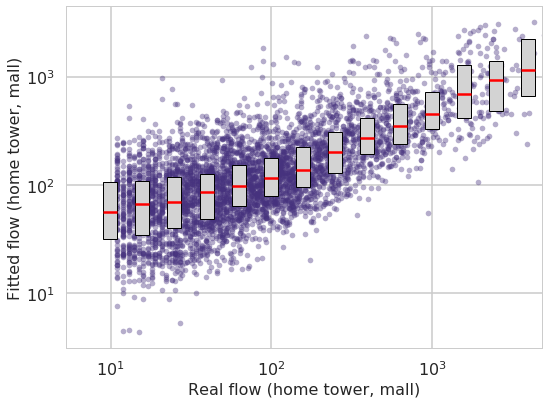

In [710]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
axes.plot(X.F_ij, X.g_ij,'.', alpha=0.4, zorder=1)
bxp=axes.boxplot(flows_exp_model_data, positions=10**(np.arange(dmin,dmax+1,1)*0.2), showfliers=False, showcaps=False, whis=0, widths=0.20*10**(np.arange(dmin,dmax+1,1)*0.2), patch_artist=True, medianprops=dict(linestyle='-.', linewidth=2.5, color='red'))
for t in bxp['boxes']:
    t.set_facecolor('lightgray')
plt.xlabel("Real flow (home tower, mall)", fontsize=16)
plt.ylabel("Fitted flow (home tower, mall)", fontsize=16)
plt.tick_params(labelsize=16)
plt.xlim(5.3,4800)
#plt.ylim(4,3000)
plt.loglog()
plt.tight_layout()
fig.savefig('figure7.png')

In [711]:
print(stats.pearsonr(X.F_ij, X.g_ij))
print(stats.spearmanr(X.F_ij, X.g_ij))

print(stats.pearsonr(np.log(X.F_ij), np.log(X.g_ij)))
print(stats.spearmanr(np.log(X.F_ij), np.log(X.g_ij)))

(0.6487583559428498, 0.0)
SpearmanrResult(correlation=0.6175800595911565, pvalue=0.0)
(0.669900380394015, 0.0)
SpearmanrResult(correlation=0.6175800595911565, pvalue=0.0)


In [712]:
from sklearn.metrics import r2_score
r2_score(X.F_ij, X.g_ij)

0.4202884710714033

#### Conditional visitation probability model

In [486]:
M = pd.read_csv("data/malls_similarity.csv")

In [487]:
M["ones"] = 1
M["logdistance"] = -np.log(M.distance)
M["logsimilarity"] = np.log(M.similarity)
M["logmall_surface"] = np.log(M.mall_j_rental_space)

In [488]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [566]:
modelLogit = sm.Logit(M.pj_given_i, M[["ones", "logmall_surface", "logsimilarity", "logdistance"]])
resultLogit = modelLogit.fit()
print(resultLogit.summary(xname=["logG", "beta", "lambda", "gamma"]))

Optimization terminated successfully.
         Current function value: 0.343303
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             pj_given_i   No. Observations:                   51
Model:                          Logit   Df Residuals:                       47
Method:                           MLE   Df Model:                            3
Date:                Fri, 20 Apr 2018   Pseudo R-squ.:                 0.02799
Time:                        20:33:36   Log-Likelihood:                -17.508
converged:                       True   LL-Null:                       -18.013
                                        LLR p-value:                    0.7993
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
logG          -3.6663      5.653     -0.649      0.517     -14.746       7.414
beta           0.2623      0.

In [567]:
prob = modelLogit.predict(resultLogit.params)

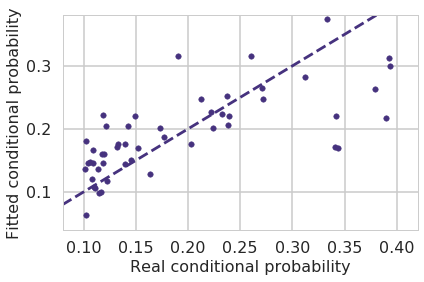

In [491]:
plt.scatter(M.pj_given_i, prob, s=30)
plt.xlabel("Real conditional probability", fontsize=16)
plt.ylabel("Fitted conditional probability", fontsize=16)
plt.plot([0,1], [0,1], '--')
plt.xlim([0.08, 0.42])
plt.ylim([0.04, 0.38])
plt.tight_layout()
plt.savefig("prediction_cond_prob.png", dpi=200)

In [568]:
print(stats.pearsonr(M.pj_given_i, prob))
print(stats.spearmanr(M.pj_given_i, prob))

(0.7074633049459014, 6.468698580047965e-09)
SpearmanrResult(correlation=0.755475113122172, pvalue=1.4852445417350175e-10)


In [492]:
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

def kde_scipy(x, x_grid, bandwidth=0.02, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

In [493]:
scipy_kde_idh = dict()
scipy_kde_idh_fitted = dict()

In [502]:
X[X.mall_id==mall_id]

,mall_id,mall_description,mall_idh,mall_lat,mall_lon,mall_rental_space,mall_visitors,home_lat,home_lon,home_population,home_idh,distance_home_mall,F_ij,logNi,logNj,logdij,ones,max_idh,max_idh2,g_ij
1507,9.0,Espacio Urbano Puente Alto,0.757265,-33.59989,-70.5749,25500,77153,-33.62,-70.63,1368.907578,0.720844,5.999913,68,7.221768,10.146434,-1.791745,1,-0.036421,0.000000,98.221293
1508,9.0,Espacio Urbano Puente Alto,0.757265,-33.59989,-70.5749,25500,77153,-33.59,-70.66,1608.315585,0.695877,8.420036,41,7.382943,10.146434,-2.130614,1,-0.061388,0.000000,63.622779
1509,9.0,Espacio Urbano Puente Alto,0.757265,-33.59989,-70.5749,25500,77153,-33.59,-70.65,9536.094469,0.689951,7.502442,50,9.162839,10.146434,-2.015229,1,-0.067314,0.000000,109.808870
1510,9.0,Espacio Urbano Puente Alto,0.757265,-33.59989,-70.5749,25500,77153,-33.59,-70.64,9871.208195,0.689951,6.587346,38,9.197378,10.146434,-1.885151,1,-0.067314,0.000000,132.467903
1511,9.0,Espacio Urbano Puente Alto,0.757265,-33.59989,-70.5749,25500,77153,-33.59,-70.63,6038.190464,0.689951,5.675955,15,8.705860,10.146434,-1.736239,1,-0.067314,0.000000,146.339845
1512,9.0,Espacio Urbano Puente Alto,0.757265,-33.59989,-70.5749,25500,77153,-33.59,-70.62,28988.003403,0.707822,4.770392,882,10.274637,10.146434,-1.562429,1,-0.049444,0.000000,261.598907
1513,9.0,Espacio Urbano Puente Alto,0.757265,-33.59989,-70.5749,25500,77153,-33.58,-70.69,9662.804257,0.726458,11.345832,6,9.176039,10.146434,-2.428850,1,-0.030807,0.000000,62.109228
1514,9.0,Espacio Urbano Puente Alto,0.757265,-33.59989,-70.5749,25500,77153,-33.58,-70.68,7106.184547,0.732005,10.438617,12,8.868721,10.146434,-2.345512,1,-0.025261,0.000000,65.211689
1516,9.0,Espacio Urbano Puente Alto,0.757265,-33.59989,-70.5749,25500,77153,-33.58,-70.66,27550.782233,0.705783,8.636520,182,10.223786,10.146434,-2.156000,1,-0.051482,0.000000,113.739793
1517,9.0,Espacio Urbano Puente Alto,0.757265,-33.59989,-70.5749,25500,77153,-33.58,-70.63,9882.911821,0.689951,5.992033,230,9.198562,10.146434,-1.790431,1,-0.067314,0.000000,151.070759


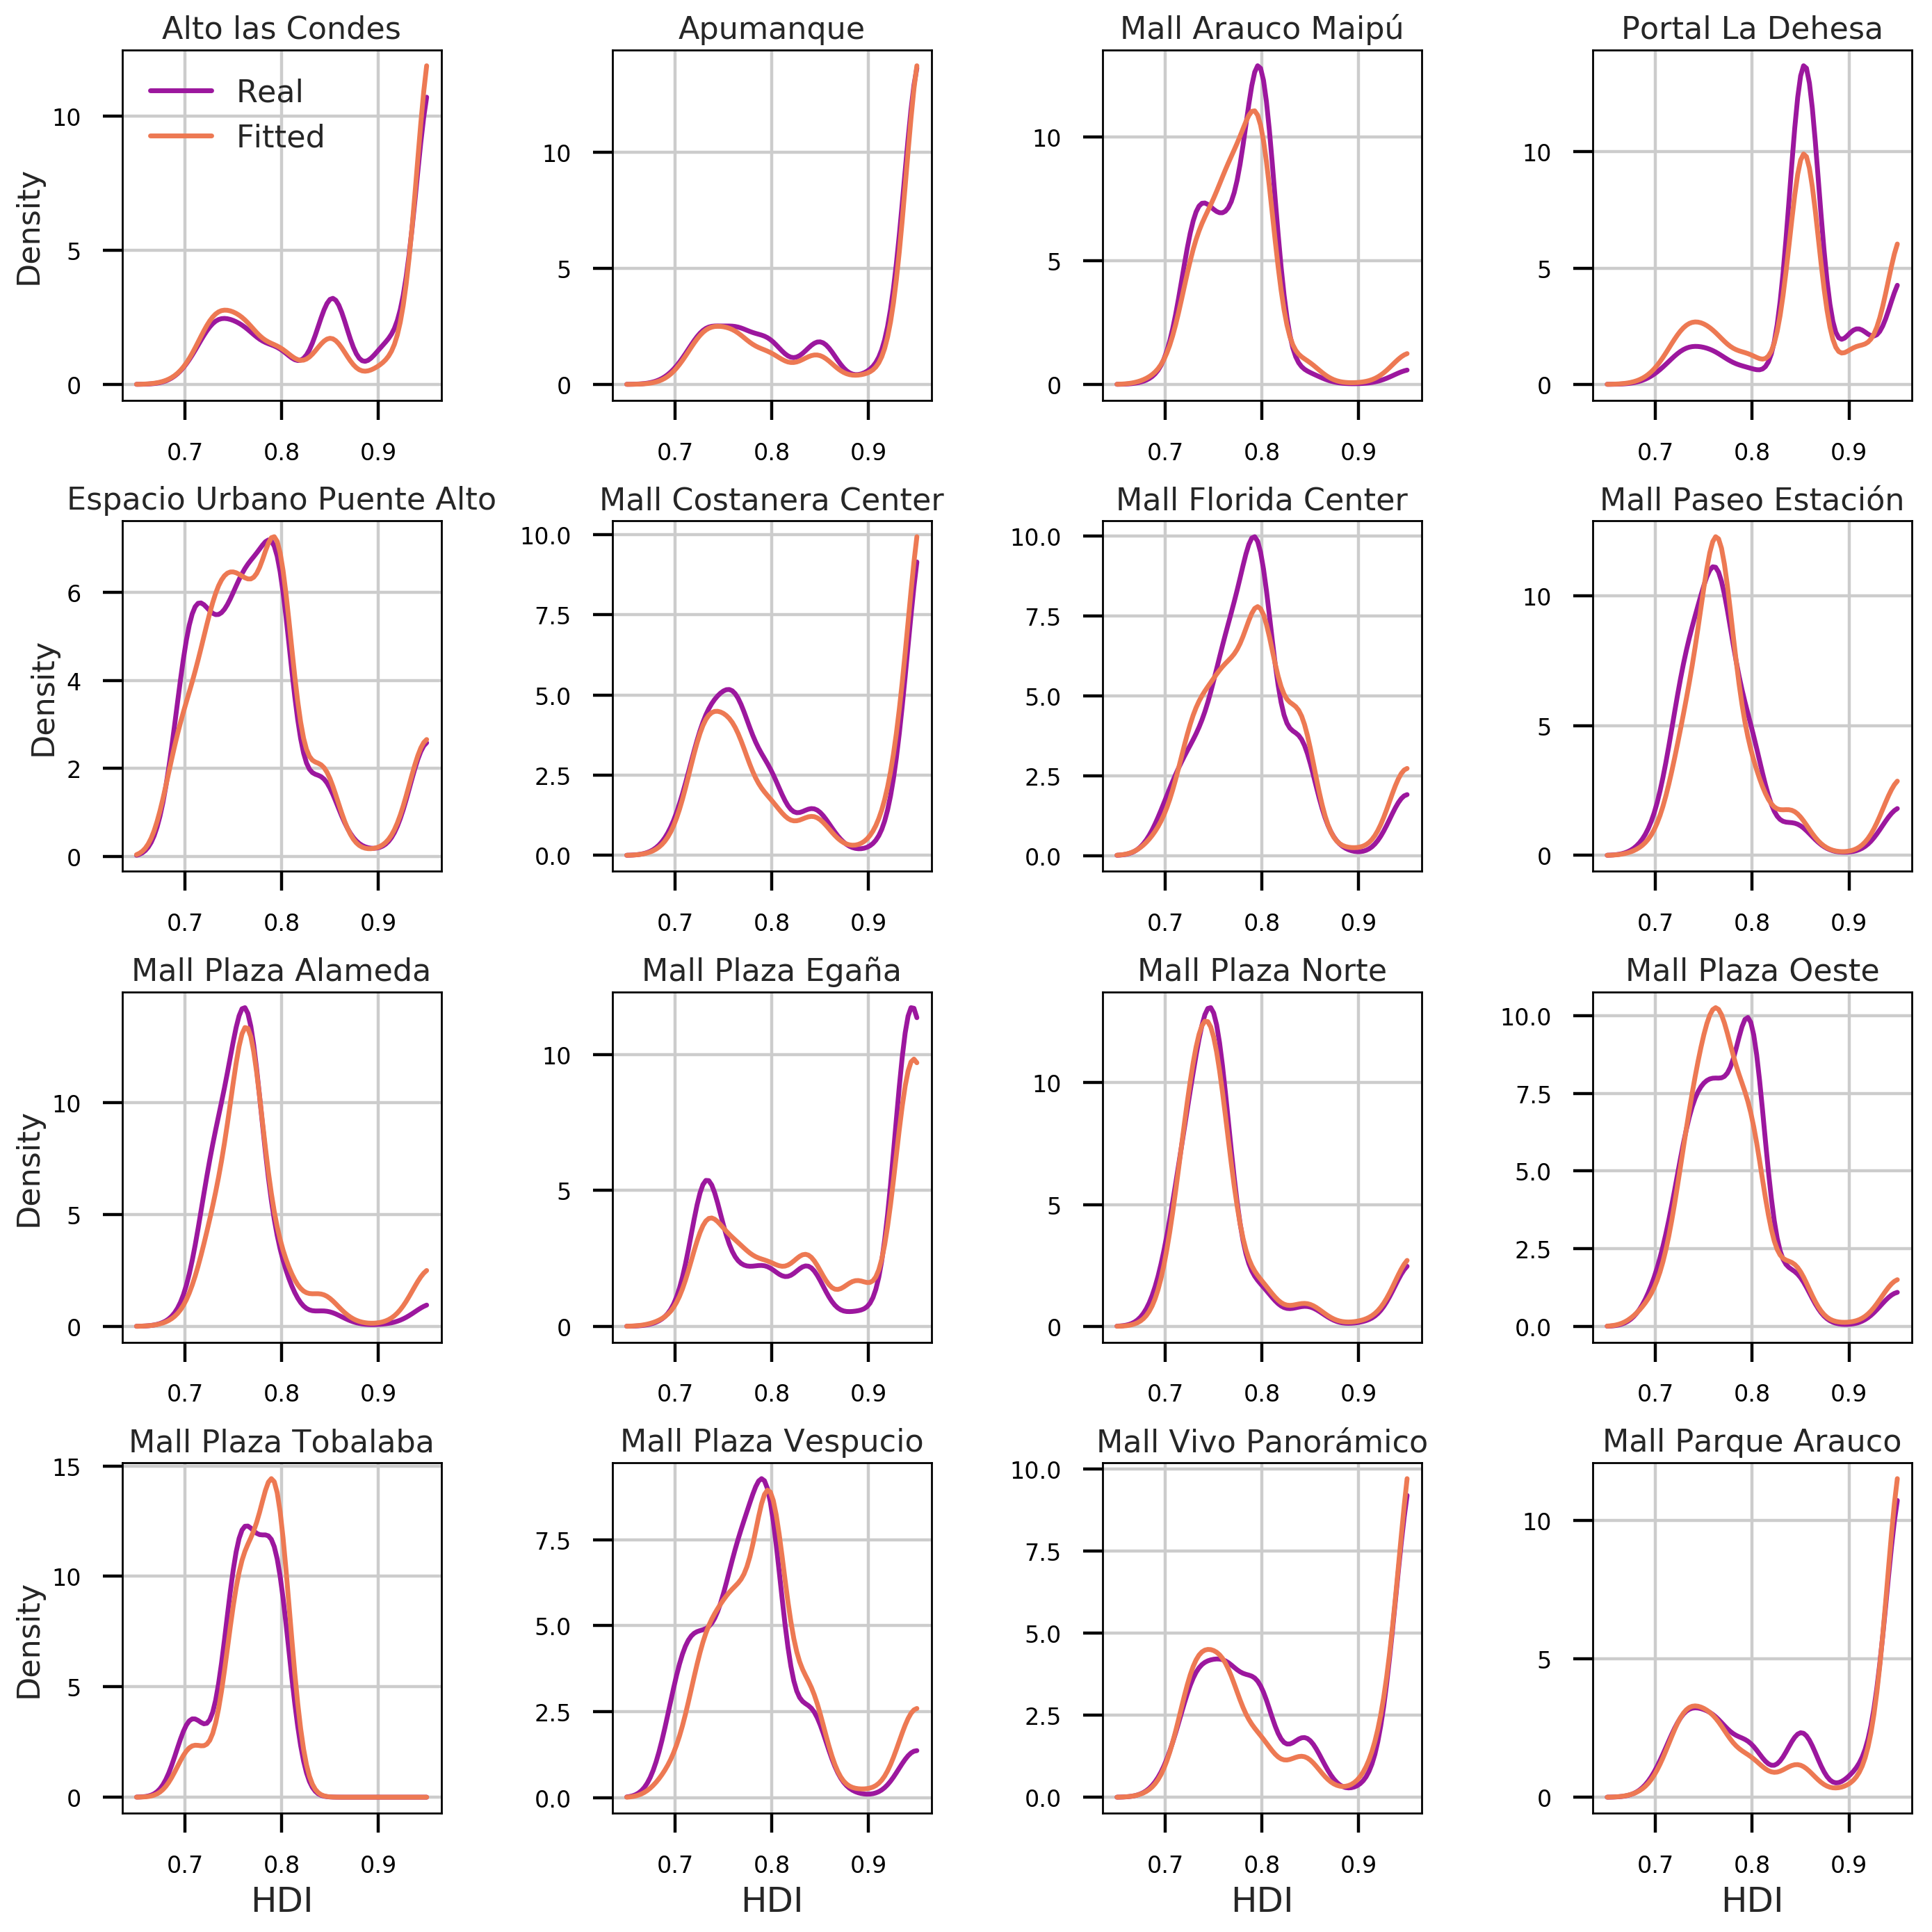

In [511]:
i = 0
f, axarr = plt.subplots(4, 4, figsize=(14,14), dpi=200)
colors = sns.color_palette('plasma', n_colors=2)
for mall_id in np.unique(X.mall_id.values):
    Vector_Mall_1 = X[X.mall_id==mall_id]
    Vector_Mall_1 = Vector_Mall_1[["home_idh", "F_ij", "g_ij", "mall_description"]]
    
    l_real = np.repeat(Vector_Mall_1.home_idh, Vector_Mall_1.F_ij)
    l_fitted = np.repeat(Vector_Mall_1.home_idh, [int(s) for s in np.round(Vector_Mall_1.g_ij)])
    
    description = Vector_Mall_1.mall_description.values[0]
    x = np.linspace(0.65, 0.95, 100)
    scipy_kde_idh[mall_id] = kde_scipy(l_real, x, 0.015)
    scipy_kde_idh_fitted[mall_id] = kde_scipy(l_fitted, x, 0.015)
    
    ax = axarr[i//4, i%4]
    i = i + 1
    ax.plot(x, scipy_kde_idh[mall_id], linewidth=2.5, label="Real", color=colors[0])
    ax.plot(x, scipy_kde_idh_fitted[mall_id], linewidth=2.5, label="Fitted", color=colors[1])
    
    ax.tick_params(color='black', labelcolor='black', size=10)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')

    ax.set_title(description, fontsize=16)
    
    if i==1:
        leg = ax.legend()
        leg.get_frame().set_edgecolor('white')
        leg.fontsize = 14
    zed = [tick.label.set_fontsize(12) for tick in ax.xaxis.get_major_ticks()]
    zed = [tick.label.set_fontsize(12) for tick in ax.yaxis.get_major_ticks()]
    if (i-1)//4==3:
        ax.set_xlabel("HDI", fontsize=18)
    if i%4==1:
        ax.set_ylabel("Density", fontsize=16)
    plt.tight_layout()
    plt.savefig("mall_curves.png")

#### Appendix: Observing data overdispersion

Here we show that data does not meet the condition for a Poissonian regression model, by:

(a) Plotting the residuals of the Poisson regression; and

(b) Computing a dispersion index as the average ratio between the squares of the residuals and the fitted flows.

In [713]:
fam = Poisson()
ind = Independence()
modelPoisson = sm.GLM(X.F_ij, X[["ones", "logNi", "logNj", "logdij"]], family = Poisson())
resultPoisson = modelPoisson.fit()
print(resultPoisson.summary(xname=["logG", "alpha", "beta", "gamma"], yname="F_ij"))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   F_ij   No. Observations:                 4827
Model:                            GLM   Df Residuals:                     4823
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:            -4.0511e+05
Date:                Fri, 04 May 2018   Deviance:                   7.8021e+05
Time:                        16:15:36   Pearson chi2:                 1.26e+06
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
logG          -2.3604      0.024    -97.911      0.000      -2.408      -2.313
alpha          0.4677      0.002    283.734      0.0

In [714]:
gpoisson_ij = modelPoisson.predict(resultPoisson.params)

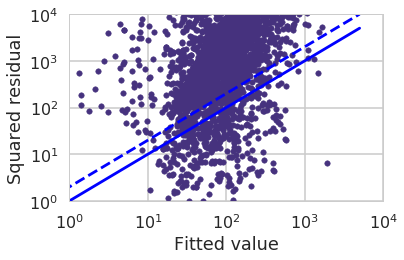

In [715]:
plt.scatter(gpoisson_ij, (gpoisson_ij-X.F_ij)**2, s=30)
plt.plot([0,5000], [0,0], color="blue", linestyle="dashed")
plt.plot([0,5000], [0,5000], color="blue")
plt.plot([0,5000], [0,10000], color="blue", linestyle="dashed")
plt.xlim([1,10000])
plt.ylim([1,10000])
plt.xlabel("Fitted value")
plt.ylabel("Squared residual")
plt.loglog()
plt.tight_layout()
plt.savefig("poisson_hyp.png")

In [716]:
np.mean((gpoisson_ij-X.F_ij)**2/gpoisson_ij)

260.2269978531467